<a href="https://colab.research.google.com/github/Ermolin/photo_32x32_classification/blob/main/classification_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
 

from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
 
import warnings
warnings.filterwarnings("ignore")

В этом ноутбуке предлагается обучить модель классификации изображений датасета CIFAR10, который содержит 60к цветных картинок разрешения 32х32 принадлежащих 10 классам.

Загрузим датасет

In [ ]:
 # из трансформаций убрал обрезание по всем краям(32х32 маловат для такого), горизонтальный разворот( перевернутые картинки требуют более сложную модель, здесь и сейчас это не имеет смысла)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    #transforms.FiveCrop(3),
    transforms.RandomPosterize(5),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Отрисуем несколько картинок, посмотрим, как выглядит наш датасет



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


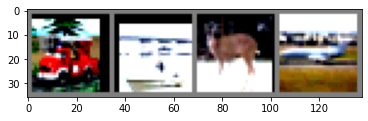

truck  ship  deer plane


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

делаем бэйс-лайн модель, модели популярных архитектур, модель 'под задачу'

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,20, kernel_size=5 , stride=(1,1) , bias=True),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2 , stride=2),
    nn.Conv2d(20,20, kernel_size=5 , stride=(1,1) , bias=True),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2 , stride=2),
    nn.Flatten(),
    nn.Linear(in_features=20*5*5, out_features=10, bias=True)
)

In [ ]:
#Resnet модель не дала достаточно высоких результатов
class Rnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Maxpool = nn.MaxPool2d(2, 2)
        self.Maxpool3 = nn.MaxPool2d(3, 3)
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5)
        self.conv2 = nn.Conv2d(6, 40, kernel_size = 3)
        #self.conv3 = nn.Conv2d(48, 48, kernel_size = 5)
        #self.conv4 = nn.Conv2d(24, 48, kernel_size = 3)
        self.fc1 = nn.Linear(1440, 4000)
        self.fc2 = nn.Linear(4000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(1000, 1000)
        self.fc32 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fcfin = nn.Linear(100, 10)

    def forward(self, x):
        x = self.Maxpool(nn.Tanh()(self.conv1(x)))
        x = self.Maxpool(nn.Tanh()(self.conv2(x)))
        #x = self.Maxpool(nn.Tanh()(self.conv3(x)))
        #x = self.Maxpool(nn.Tanh()(self.conv4(x)))
        x = nn.Flatten()(x)
        x = nn.Tanh()(self.fc1(x))
        x = nn.Tanh()(self.fc2(x))
        x = nn.Tanh()(self.fc3(x))
        x = nn.Tanh()(self.fc31(x))
        x = nn.Tanh()(self.fc32(x))
        x = nn.Tanh()(self.fc4(x))
        x = nn.Tanh()(self.fc5(x))
        x = nn.Softmax()(self.fcfin(x))
        return x


rnet = Rnet()

In [ ]:
# Gnet, сделанный по аналогии с гугловкой сеткой не влезает на гпу, не используем его =С
class Gnet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.Maxpool = nn.MaxPool2d(2, 2)
        self.Maxpool2 = nn.MaxPool2d(2, 2)

        self.conv1x1 = nn.Conv2d(3, 3, kernel_size = 1)
        #self.conv2x2 = nn.Conv2d(6, 40, kernel_size = 3)
        self.conv3x3 = nn.Conv2d(3, 12, kernel_size = 3)
        self.conv5x5 = nn.Conv2d(3, 36, kernel_size = 5)

        #self.concat = np.concatenate()
        #((32*32*3) +(30*30*12) + (30*30*12) + (28*28*36) +(16*16*3) )
        self.fc1 = nn.Linear(42864, 21432)
        self.fc2 = nn.Linear(21432, 1000)
        self.fc3 = nn.Linear(1000, 100)
        #self.fc31 = nn.Linear(1000, 1000)
        #self.fc32 = nn.Linear(1000, 1000)
        #self.fc4 = nn.Linear(1000, 100)
        #self.fc5 = nn.Linear(100, 100)
        self.fcfin = nn.Linear(100, 10)

    def forward(self, x):
        x1 = self.conv3x3((self.conv1x1(x)))
        x2 = self.conv5x5((self.conv1x1(x)))
        x3 = self.conv1x1((self.Maxpool2(x)))
        x4 = self.conv1x1(x)
        x1 = nn.Flatten()(x1)#.detach().cpu().numpy()
        x2 = nn.Flatten()(x2)#.detach().cpu().numpy()
        x3 = nn.Flatten()(x3)#.detach().cpu().numpy()
        x4 = nn.Flatten()(x4)#.detach().cpu().numpy()
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = nn.Tanh()(self.fc1(x))
        x = nn.Tanh()(self.fc2(x))
        x = nn.Tanh()(self.fc3(x))
        #x = nn.Tanh()(self.fc31(x))
        #x = nn.Tanh()(self.fc32(x))
        #x = nn.Tanh()(self.fc4(x))
        #x = nn.Tanh()(self.fc5(x))
        x = nn.Softmax()(self.fcfin(x))
        return x


gnet = Gnet()

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.Maxpool = nn.MaxPool2d(2,2)
        self.Avgpool = nn.AvgPool2d(2,2)
        self.conv1 = nn.Conv2d(3 , 64 , kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

    def forward(self, x):
        x = self.Maxpool(nn.LeakyReLU()(self.conv1(x)))
        x = self.Maxpool(nn.LeakyReLU()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.LeakyReLU()(nn.Linear(5*5*64 , 1000)(x))
        x = nn.Softmax()(nn.Linear(1000, 10)(x))
        return x


vgg = VGG()

In [ ]:
# Рабочая модель, модифицировал исходя из того, что 32х32- сетка и так достаточно маленькая, минимизирую количество пулов
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Maxpool = nn.MaxPool2d(2, 2)
        self.Avgpool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(32, 96, kernel_size = 5)
        self.fc1 = nn.Linear(96 * 5 * 5, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        #self.fc22 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)

    def forward(self, x):
        x = self.Maxpool(nn.Tanh()(self.conv1(x)))
        x = self.Maxpool(nn.Tanh()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.Tanh()(self.fc1(x))
        x = nn.Tanh()(self.fc2(x))
        #x = nn.Tanh()(self.fc22(x))
        x = nn.Softmax()(self.fc3(x))
        return x


net = Net()

Закинем модель на ГПУ. Выберем в качестве лосс-функции кросс-энтропию. В качестве оптимизатора возьмем Адам.

In [ ]:
#net = net.cuda()
#model = model.cuda()
#vgg = vgg.cuda()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters())

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Обучим модель

In [ ]:
def acc_score(for_check):
  for X_batch, y_batch in testloader:
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    with torch.no_grad():
        predictions = for_check(X_batch)

    true_lab = y_batch.cpu().numpy()
    _, preds = torch.max(predictions, dim=1)
    # print(true_lab)
    # print(preds)
    print('accuracy_score: ', accuracy_score(true_lab, preds.detach().cpu().numpy()))


In [ ]:
def learn(modeli , epochs):
  modeli = modeli.cuda()
  optimizer = optim.Adam(modeli.parameters())
  for epoch in range(epochs):  

    for X_batch, y_batch in tqdm(trainloader):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        optimizer.zero_grad()

        predictions = modeli(X_batch)

        loss = criterion(predictions, y_batch)
        loss.backward()

        optimizer.step()

Посчитаем точность предсказания на валидационной выборке.

In [ ]:
learn(net , 20)
acc_score(net)

100%|██████████| 49/49 [00:14<00:00,  3.49it/s]


accuracy_score:  0.65


Задача- попасть в accuracy_score = 0.65
Модель "Net" - созданная под задачу справилась, при этом затратила всего 20 поколений и менее 5 минут.

